# Taylor's Power Law

In [1]:
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

from doe_modules.design import PlackettBurman, DOE, FullFactorial
from doe_modules.plot import bio_multicomp
from doe_modules.preferences import kwarg_savefig, outputdir
from doe_modules.simulation import AbstractSimulator, Sim1, Circuit, MLR, Sparse

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir

conf = Config()

In [4]:
noise_conf = [
    dict(kwarg_err=dict(loc=0, scale=.5)),
    dict(kwarg_err=dict(loc=0, scale=1)),
    dict(kwarg_err=dict(loc=0, scale=2)),
    dict(kwarg_err=dict(loc=0, scale=4)),
]

noise_names = [
    r"$\sigma=0.5$",
    r"$\sigma=1$",
    r"$\sigma=2$",
    r"$\sigma=4$"
]

simulators = dict(
    sim1=list(map(lambda x: x(), [Sim1] * len(noise_conf))), 
    circuit=list(map(lambda x: x(), [Circuit] * len(noise_conf))), 
    sparse=list(map(lambda x: x(), [Sparse] * len(noise_conf)))
)

exmatrix = FullFactorial().get_exmatrix(n_factor=9)()
n_rep = 10

np.random.seed(0)
random_state = np.random.randint(0, 2**32, len(simulators) * len(noise_conf))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

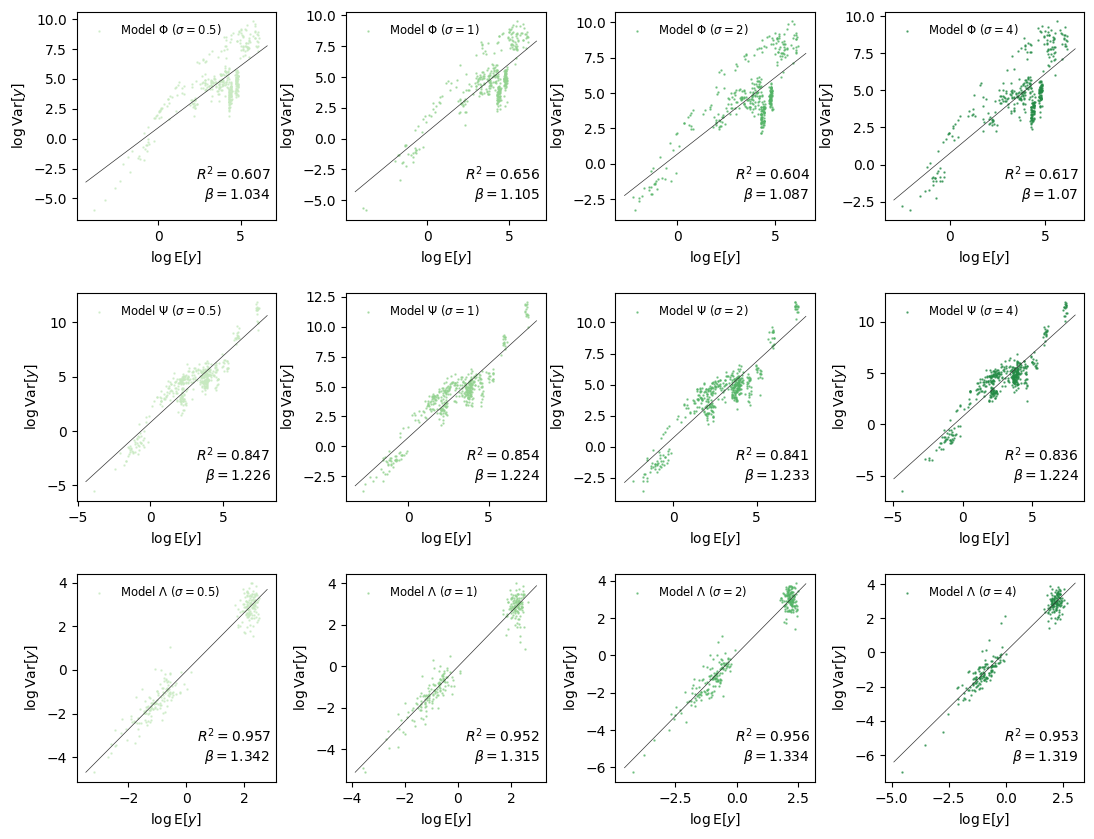

In [5]:
fig, ax = plt.subplots(len(simulators), len(noise_names), figsize=(13, 10))
plt.subplots_adjust(hspace=.35, wspace=.35)

for i, model_list in tqdm(enumerate(simulators.values()), total=len(simulators)):
    for ii, model in tqdm(enumerate(model_list), total=len(model_list)):
        np.random.seed(random_state[len(noise_conf) * i + ii])
        seeds = np.random.randint(0, 2**32, len(exmatrix) * n_rep)
        
        expressions = []
        output = []
        for iii, s in enumerate(seeds):
            model.run(exmatrix.iloc[iii // n_rep, :], random_state=s)
            expressions += [list(model.x.values())]
            output += [[model.y]]
        
        ym = np.array(output).reshape(-1, n_rep).mean(axis=1)
        yv = np.array(output).reshape(-1, n_rep).var(axis=1)
        pos_idx = np.where(ym > 0)
        
        ym, yv = ym[pos_idx], yv[pos_idx]

        lrm = LinearRegression()
        lrm.fit(np.log(ym).reshape(-1, 1), np.log(yv))

        ax[i, ii].scatter(
            np.log(ym), np.log(yv), s=.5, color=plt.cm.Greens((ii + 1.5)/ (len(noise_conf) + 2)), 
            label=f"{model.name} ({noise_names[ii]})", alpha=.7,
            rasterized=True
        )

        xlim, ylim = ax[i, ii].get_xlim(), ax[i, ii].get_ylim()

        ax[i, ii].plot(
            xlim, lrm.coef_ * np.array(xlim) + lrm.intercept_, 
            lw=.5, c=".2",
        )

        ax[i, ii].set(
            # title=model.name,
            xlabel="$\log$" + "E" + "$[y]$", ylabel="$\log$" + "Var" + "$[y]$"
        )
        ax[i, ii].legend(fontsize="small", loc="upper left", frameon=False)
        
        xlim, ylim = ax[i, ii].get_xlim(), ax[i, ii].get_ylim()
        ax[i, ii].text(
            max(xlim), min(ylim), 
            r"$R^2=$" + f"{round(lrm.score(np.log(ym).reshape(-1, 1), np.log(yv)), 3)}"  + "  \n" + \
            r"$\beta=$" + f"{lrm.coef_.round(3).item()}  \n", 
            ha="right", va="bottom"
        )
        ax[i, ii].set_xlim(*xlim)
        ax[i, ii].set_ylim(*ylim)

if conf.savefig:
    fig.savefig(f"{conf.out}/taylor.pdf", **kwarg_savefig)